# Network Analysis
Reads SUMO network and prepares dictionary python files for multi-intersection AIM control.

Preconditions of SUMO network: number of lanes at one edge should not change (no lane widening nearby intersection), separate lanes for all modes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import math
import json
from shapely import geometry, ops, wkt
from shapely.geometry import MultiLineString, LineString, Point
import xml.etree.ElementTree as ET
from adjustText import adjust_text
from matplotlib.font_manager import FontProperties

## 1st Step: Network and Section Topology
Has to be run once for a simulation network.

#### Required: insert net.xml file

In [2]:
net_file = 'K1_AIM.net.xml'

#### Required: initiate dataframes

In [3]:
sections_df = pd.DataFrame(columns=['sumo_id', 'road_users', 'geometry', 'length'])
intersections_df = pd.DataFrame(columns=['sumo_id', 'geometry'])

Additionally, the following geodataframes are defined in the course of the notebook:
    -sections_gdf
    -intersections_gdf
    -vru_sections_gdf
    -vehicle_sections_gdf

#### Required: Extracts sections and intersections from net.xml

In [4]:
#bei den edges sind entry und exit nodes, lanes, length und shape interessant
#bei junctions sind incLanes, shapes (und intLanes) interessant

#read net.xml
tree = ET.parse(net_file)
root = tree.getroot()

# read out edges 
for edge in root.findall('edge'): 
    function = edge.get('function')
    # all edges that are not internal, walkingareas or crossings
    if (function != 'internal' and function != 'walkingarea' and function != 'crossing'):
        # check which road users are allowed on the edge
        road_users = []
        #include all lanes
        for child in edge:
            if child.get('allow'):
                road_users.append(child.get('allow'))
            if child.get('disallow')  == "pedestrian bicycle" or child.get('disallow')  == "pedestrian":
                road_users.append("vehicle")
        #shape is needed for plotting
        shape = edge[0].get('shape').split(" ")
        shape = [eval(i) for i in shape]
        shape = LineString(shape)
        sections_df = sections_df.append({'sumo_id': edge.get('id'), 'road_users': road_users, 'geometry': shape, 'length': edge[0].get('length')}, ignore_index=True)

#import junctions -> intersections
for junction in root.findall('junction'): 
    jtype = junction.get('type')
    #all intersections that are not dead end
    if (jtype != 'dead_end' and jtype != 'internal'):
        #incLanes have to be written in quotation marks to topology
        incLanes = junction.get('incLanes').split(" ")
        #shape is needed for plotting
        shape = junction.get('shape').split(" ")
        shape = [eval(i) for i in shape]
        shape = LineString(shape)
        intersections_df = intersections_df.append({'sumo_id': junction.get('id'),'geometry': shape}, ignore_index=True)

print(sections_df)
print(intersections_df)

  sumo_id                      road_users  \
0     -E0  [pedestrian, bicycle, vehicle]   
1     -E1  [pedestrian, bicycle, vehicle]   
2     -E2  [pedestrian, bicycle, vehicle]   
3     -E3  [pedestrian, bicycle, vehicle]   
4      E0  [pedestrian, bicycle, vehicle]   
5      E1  [pedestrian, bicycle, vehicle]   
6      E2  [pedestrian, bicycle, vehicle]   
7      E3  [pedestrian, bicycle, vehicle]   

                                            geometry  length  
0  LINESTRING (875.45 806.76, 784.84 755.87, 716....  271.01  
1  LINESTRING (619.4 723.66, 604.6 822.16, 553.22...  278.00  
2  LINESTRING (606.98 719.29, 553.65 712.03, 511....  285.78  
3  LINESTRING (611.54 706.6900000000001, 655.41 4...  270.59  
4  LINESTRING (623.87 711.24, 718.6799999999999 7...  273.54  
5  LINESTRING (543.26 990.27, 594.21 819.88, 609....  276.98  
6  LINESTRING (398 547.27, 479.65 656.57000000000...  280.19  
7           LINESTRING (665.67 441.37, 621.8 708.38)  270.59  
  sumo_id                  

#### Required: Save geodataframe to geojson for vehicle demand

In [5]:
# create geodataframes
sections_gdf = gpd.GeoDataFrame(sections_df, geometry = 'geometry')
intersections_gdf = gpd.GeoDataFrame(intersections_df, geometry = 'geometry')
vehicle_sections_gdf = sections_gdf[sections_gdf['road_users'].apply(lambda x: 'vehicle' in x)]
vehicle_sections_gdf = vehicle_sections_gdf.loc[:, ['sumo_id', 'geometry']]
# create VRU gdf with bicycle sections; pedestrian sections are added afterwards
vru_sections_gdf = sections_gdf[sections_gdf['road_users'].apply(lambda x: 'bicycle' in x)]
vru_sections_gdf = vru_sections_gdf.loc[:, ['sumo_id', 'road_users', 'geometry', 'length']]
vru_sections_gdf['road_users'] = 'bicycle'

# Save geodataframes to geoJson so that it can fastly be reloaded
vehicle_sections_gdf.to_file('vehicle_sections.geojson', driver='GeoJSON')

#### Optional: Plot section and intersection ids

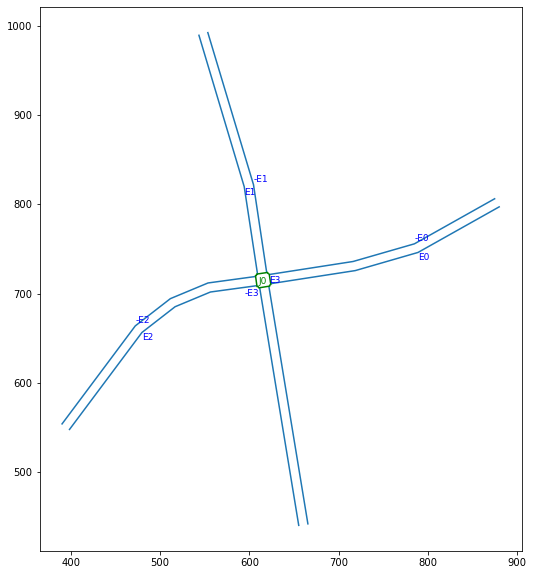

In [6]:
#plot network with sections and intersections

fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect('equal')

#plot ids nearby elements; aplly adjust_text to avoid overlapping elements
sections_gdf['coords'] = sections_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
sections_gdf['coords'] = [coords[0] for coords in sections_gdf['coords']]
sections_gdf.plot(ax = ax)
texts = []
for index, row in sections_gdf.iterrows():
    texts.append(plt.annotate(text = row['sumo_id'], xy = row['coords'], size = 9, color = 'blue'))
    
intersections_gdf['coords'] = intersections_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
intersections_gdf['coords'] = [coords[0] for coords in intersections_gdf['coords']]    
intersections_gdf.plot(ax = ax, color = 'green')
for index, row in intersections_gdf.iterrows():
    texts.append(plt.annotate(text = row['sumo_id'], xy = row['coords'], size = 9, color = 'green'))
    
adjust_text(texts)
plt.savefig('network.png', dpi = 600)
   
plt.show()

## 2nd Step: Intersection Topology
Has to be run once for each intersection.

#### Required: insert intersection id and width of road users

In [7]:
intersection_id = 'J0' # input: sumo junction id
# input: dimensions for conflict region calculation
width_vehicle = 2.0 
length_vehicle = 5.0
width_bicycle = 1.5
length_bicycle = 2.0
width_ped_crossing = 2.0

#### Required: initiate dataframes

In [8]:
connections_df = pd.DataFrame(columns=['connection_id', 'fromEdge', 'toEdge', 'fromLane', 'toLane', 'turning_direction', 'RU', 'length', 'geometry', 'startpoint', 'endpoint'])
intersection_points_df = pd.DataFrame(columns=['connection_id_a', 'connection_id_b','geometry'])
omega_values_df = pd.DataFrame(columns=['connection_a', 'connection_b', 'RU_a', 'RU_b', 'geometry_a', 'geometry_b', 'distance_a', 'distance_b','angle', 'om1_a', 'om1_b', 'om2_a', 'om2_b'])

Additionally, the following geodataframes are defined in the course of the notebook:
    -connections_gdf
    -intersection_points_gdf
    -omega_values_gdf

#### Required: Reads net xml to find connections inside intersection area

In [9]:
#parsing the net.xml file
tree = ET.parse(net_file)
root = tree.getroot()
to_connect = pd.DataFrame(columns=['connection_id_a', 'connection_id_b','ind_to_drop'])
counter_intLanes = 0 #counting which index in the dataframe has to be dropped later on
    
#find all lanes that have the function internal  
for lane in root.findall("./edge[@function='internal']/lane"):
    connection_id = lane.get('id')

    #check if connection_id contains junction_id-> is an internal lane
    if intersection_id in connection_id:
        #transfer lane_shp string to shapely LineString
        lane_shp = lane.get('shape')
        lane_shp = lane_shp.split(" ")
        lane_shp = [eval(i) for i in lane_shp]
        startpoint = Point(lane_shp[0])
        endpoint = Point(lane_shp[-1])
        
        #check which road user is allowed on connection
        road_user = lane.get('allow')
        if road_user == "bicycle":
            road_user = road_user
        else:
            road_user = "vehicle"            
        
        for connection in root.findall('connection'):
            con_id = connection.get('via')
            if con_id == connection_id:
                startedge = connection.get('from')
                endedge = connection.get('to')
                startlane = connection.get('fromLane')
                endlane = connection.get('toLane')
                turn_dir = connection.get('dir')
                
                #check for shapes to connect
                if 'E' not in startedge:
                    for junction in root.findall("./junction[@type='internal']"):
                        if junction.get('id') == connection_id:
                            incLanes = junction.get('incLanes')
                            incLanes = incLanes.split(" ")
                            previous_connection = incLanes[0]
                            to_connect = to_connect.append({'connection_id_a': previous_connection,'connection_id_b': connection_id, 'ind_to_drop': counter_intLanes}, ignore_index=True)
                    
        counter_intLanes = counter_intLanes + 1 
        #save to dataframe
        connections_df = connections_df.append({'connection_id': connection_id, 'fromEdge': startedge, 'toEdge': endedge, 'fromLane': startlane, 'toLane': endlane, 'turning_direction': turn_dir, 'RU': road_user, 'geometry': lane_shp, 'startpoint':startpoint, 'endpoint': endpoint}, ignore_index=True)

for edge in root.findall("./edge[@function='crossing']"):
    edges = edge.get('crossingEdges')
    edges = edges.split(" ")
    startedge = edges[0]
    endedge = edges[1]
    # find all lanes that have the function crossing   
    # for lane in root.findall("./edge[@function='crossing']/lane"):
    for lane in edge.findall("./lane"):
        connection_id = lane.get('id')

        #check if connection_id contains junction_id-> is an internal lane
        if intersection_id in connection_id:
            length = lane.get('length')
            #transfer lane_shp string to shapely LineString
            lane_shp = lane.get('shape')
            lane_shp = lane_shp.split(" ")
            lane_shp = [eval(i) for i in lane_shp]
            startpoint = Point(lane_shp[0])
            endpoint = Point(lane_shp[-1])
            road_user = "pedestrian" 
            counter_intLanes = counter_intLanes + 1
            #save to dataframe
            connections_df = connections_df.append({'connection_id': connection_id, 'fromEdge': startedge, 'toEdge': endedge, 'RU': road_user, 'length': length, 'geometry': lane_shp, 'startpoint':startpoint, 'endpoint': endpoint}, ignore_index=True)

print(connections_df)
print(to_connect)


   connection_id fromEdge toEdge fromLane toLane turning_direction  \
0        :J0_0_0      -E0    -E1        1      1                 r   
1        :J0_1_0      -E0    -E2        1      1                 s   
2        :J0_2_0      -E0    -E3        1      1                 l   
3        :J0_3_0      -E0    -E1        2      2                 r   
4        :J0_4_0      -E0    -E2        2      2                 s   
5        :J0_5_0      -E0    -E3        2      2                 l   
6       :J0_24_0    :J0_0    -E1        0      1                 r   
7       :J0_25_0    :J0_2    -E3        0      1                 l   
8       :J0_26_0    :J0_3    -E1        0      2                 r   
9       :J0_27_0    :J0_5    -E3        0      2                 l   
10       :J0_6_0       E3     E0        1      1                 r   
11       :J0_7_0       E3    -E1        1      1                 s   
12       :J0_8_0       E3    -E2        1      1                 l   
13       :J0_9_0    

#### Visualization: plot incomplete connections

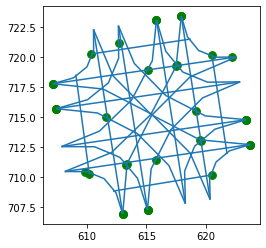

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
incomplete_connections = pd.DataFrame({'geometry': connections_df['geometry'], 'endpoint': connections_df['endpoint']})
for j in incomplete_connections.index:
    incomplete_connections['geometry'][j] = LineString(incomplete_connections['geometry'][j])   
    
incomplete_connections_gdf = gpd.GeoDataFrame(incomplete_connections, geometry = 'geometry')
incomplete_connections_gdf.plot(ax = ax)
incomplete_connections_gdf.set_geometry('endpoint').plot(ax = ax, marker = 'o', color = 'green', markersize = 60)
plt.savefig('incomplete_connections.png', dpi=600)
plt.show()

#### Required: Connect incomplete connection, create LineStrings to enable visualisation

In [11]:
#connect incomplete intLanes and create LineStrings
to_drop = list()
for j in connections_df.index:
    for i in to_connect.index:
        ind_to_drop = to_connect['ind_to_drop'][i]
        to_drop.append(ind_to_drop)
        #connect shapes    
        if to_connect['connection_id_a'][i] == connections_df['connection_id'][j]:
            #adapt line_ids
            connections_df['connection_id'][j] = connections_df['connection_id'][j] + ' - ' + to_connect['connection_id_b'][i]
            #shapes: connect shape
            connections_df['geometry'][j] = sum([connections_df['geometry'][j], connections_df['geometry'][ind_to_drop]], [])
            #endpoints: take endpoint from the second shape 
            connections_df['endpoint'][j] = connections_df['endpoint'][ind_to_drop] 
            
        #convert all shapes to LineString objects
    connections_df['geometry'][j] = LineString(connections_df['geometry'][j])
#drop incomplete intLanes                                  
connections_df = connections_df.drop(connections_df.index[to_drop], axis = 0)
connections_df = connections_df.reset_index()
connections_df = connections_df.drop('index', axis=1)

print(connections_df)

          connection_id fromEdge toEdge fromLane toLane turning_direction  \
0    :J0_0_0 - :J0_24_0      -E0    -E1        1      1                 r   
1               :J0_1_0      -E0    -E2        1      1                 s   
2    :J0_2_0 - :J0_25_0      -E0    -E3        1      1                 l   
3    :J0_3_0 - :J0_26_0      -E0    -E1        2      2                 r   
4               :J0_4_0      -E0    -E2        2      2                 s   
5    :J0_5_0 - :J0_27_0      -E0    -E3        2      2                 l   
6               :J0_6_0       E3     E0        1      1                 r   
7               :J0_7_0       E3    -E1        1      1                 s   
8               :J0_8_0       E3    -E2        1      1                 l   
9    :J0_9_0 - :J0_28_0       E3     E0        2      2                 r   
10             :J0_10_0       E3    -E1        2      2                 s   
11  :J0_11_0 - :J0_29_0       E3    -E2        2      2                 l   

#### Required: Add pedestrians to vru df and save it to geojson

In [12]:
# connections are named according to the edges they connect
for c in connections_df.index:
    if connections_df['RU'][c] == 'pedestrian':
        # extend vru dataframe and save it to geojson
        new_row = {'sumo_id': connections_df['fromEdge'][c], 'road_users': 'pedestrian', 'geometry': connections_df['geometry'][c], 'length': connections_df['length'][c] }
        vru_sections_gdf = vru_sections_gdf.append(new_row, ignore_index=True)
        vru_sections_gdf.to_file('vru_sections.geojson', driver='GeoJSON')


#### Optional: Plot connections as well as their start and endpoints

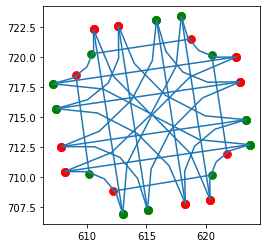

In [13]:
#plot connections
connections_gdf = gpd.GeoDataFrame(connections_df, geometry = 'geometry')

#plot connected shapes as well as start- and endpoints
fig, ax = plt.subplots()
ax.set_aspect('equal')
connections_gdf.plot(ax = ax)
connections_gdf.set_geometry('endpoint').plot(ax = ax, marker = 'o', color = 'green', markersize = 60)
connections_gdf.set_geometry('startpoint').plot(ax = ax, marker = 'o', color = 'red', markersize = 60)
plt.savefig('connections.png', dpi=600)
plt.show()

#### Required: Calculate intersection points

In [14]:
# Different types of intersection points: intersection of endpoints, intersection of startpoints and true intersection points. 
# We want the intersection of endpoints and true intersection points
# keep intersection point, if touch=False or (touch=True or intersectionpoint=endpoint)

for i in connections_df.index:
    traj_a = connections_df['geometry'][i]
    #print(a.length)
    for j in connections_df.index:  
        traj_b = connections_df['geometry'][j]
        intersection_point = traj_a.intersection(traj_b)
        if intersection_point.geom_type == 'Point':
            #true intersection points
            if traj_a.touches(traj_b) == False:           
                intersection_points_df = intersection_points_df.append({'connection_id_a': connections_df['connection_id'][i],'connection_id_b': connections_df['connection_id'][j],'geometry': intersection_point}, ignore_index=True)
            #intersection of end points
            elif traj_a.touches(traj_b) == True and intersection_point.equals(connections_df['endpoint'][i]) and intersection_point.equals(connections_df['endpoint'][j]):
                intersection_points_df = intersection_points_df.append({'connection_id_a': connections_df['connection_id'][i],'connection_id_b': connections_df['connection_id'][j],'geometry': intersection_point}, ignore_index=True)
            
print(intersection_points_df)
intersection_points_df.to_csv('file_intersectionpoints.csv')


        connection_id_a      connection_id_b  \
0    :J0_0_0 - :J0_24_0              :J0_7_0   
1    :J0_0_0 - :J0_24_0  :J0_14_0 - :J0_31_0   
2    :J0_0_0 - :J0_24_0             :J0_c0_0   
3    :J0_0_0 - :J0_24_0             :J0_c3_0   
4               :J0_1_0   :J0_3_0 - :J0_26_0   
..                  ...                  ...   
315            :J0_c3_0             :J0_19_0   
316            :J0_c3_0  :J0_20_0 - :J0_34_0   
317            :J0_c3_0  :J0_21_0 - :J0_35_0   
318            :J0_c3_0             :J0_22_0   
319            :J0_c3_0  :J0_23_0 - :J0_36_0   

                                        geometry  
0               POINT (617.91 723.4400000000001)  
1               POINT (617.91 723.4400000000001)  
2    POINT (620.4747532428527 720.1243344408778)  
3    POINT (618.5903032183454 721.5234992807378)  
4      POINT (617.59493593477 719.3218171228888)  
..                                           ...  
315  POINT (610.8926231912689 720.3656051731751)  
316  POINT (611

#### Optional: Plot connections and intersection points
check if correct intersection points were selected + are pedestrain crossings long enough?

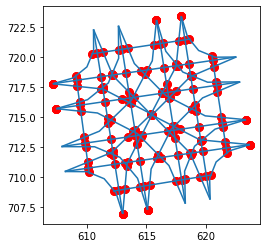

In [20]:
#transfer to a GeoDataFrame
intersection_points_gdf = gpd.GeoDataFrame(intersection_points_df, geometry = 'geometry')
intersection_points_gdf

#plot intersection points
fig, ax = plt.subplots()
ax.set_aspect('equal')
intersection_points_gdf.plot(ax = ax, marker = 'o', color = 'r', markersize = 60)
connections_gdf.set_geometry('geometry').plot(ax = ax)

plt.savefig('intersection_points.png', dpi=600)
plt.show()

#### Count intersection points per connection 

In [16]:
#list = intersection_points_df['connection_id_a'].value_counts()
intersection_point_counts = []
for index, row in connections_df.iterrows():
    connection_id = row['connection_id']
    count = len(intersection_points_df[intersection_points_df['connection_id_a'] == connection_id])    
    intersection_point_counts.append(count)

# Add the list as a new column in connections_df
connections_df['number_of_intersection_points'] = intersection_point_counts
total_intersection_points = connections_df['number_of_intersection_points'].sum()
avg_intersection_points_r = connections_df[connections_df['turning_direction'] == 'r']['number_of_intersection_points'].mean()
avg_intersection_points_l = connections_df[connections_df['turning_direction'] == 'l']['number_of_intersection_points'].mean()
avg_intersection_points_s = connections_df[connections_df['turning_direction'] == 's']['number_of_intersection_points'].mean()
print(total_intersection_points)
print(avg_intersection_points_r)
print(avg_intersection_points_l)
print(avg_intersection_points_s)
connections_df.to_csv('file_connections.csv')

320
6.0
14.0
14.0


#### Required: Calculation of conflict regions (omega_values) as basis for python files

In [16]:
#Built Omega Dataframe which is the basis for the *.py generation
omega_values_df['connection_a'] = intersection_points_df['connection_id_a']
omega_values_df['connection_b'] = intersection_points_df['connection_id_b']
         
#calculate distance to conflict point by splitting lines + fill RU, geometry, distance for connection a
for i in intersection_points_df.index:
    split_point = intersection_points_df['geometry'][i]    
    for j in connections_df.index:
        if intersection_points_df['connection_id_a'][i] == connections_df['connection_id'][j]:
            omega_values_df['RU_a'][i] = connections_df['RU'][j]
            #split has no tolerance-> first add snip point to Line using snap and then split at this point
            splitted_lines = ops.snap(connections_df['geometry'][j], split_point, 0.01)
            splitted_lines = ops.split(splitted_lines, split_point)
            #calculate distance to conflict point
            omega_values_df['geometry_a'][i] = splitted_lines[0]
            omega_values_df['distance_a'][i] = splitted_lines[0].length

#calculate the angle of intersection and omega values + fill RU, geometry, distance for connection b
for i in omega_values_df.index:
    for j in omega_values_df.index:
        if (omega_values_df['connection_a'][i] == omega_values_df['connection_b'][j]) and (omega_values_df['connection_b'][i] == omega_values_df['connection_a'][j]):
            omega_values_df['geometry_b'][i] = omega_values_df['geometry_a'][j]
            omega_values_df['distance_b'][i] = omega_values_df['distance_a'][j]
            omega_values_df['RU_b'][i] = omega_values_df['RU_a'][j]
    substring_a = ops.substring(omega_values_df['geometry_a'][i], start_dist = omega_values_df['distance_a'][i] - 0.01, end_dist = omega_values_df['distance_a'][i])
    substring_b = ops.substring(omega_values_df['geometry_b'][i], start_dist = omega_values_df['distance_b'][i] - 0.01, end_dist = omega_values_df['distance_b'][i])
    # calculate vectors
    a = np.array([substring_a.boundary[-1].x, substring_a.boundary[-1].y])-np.array([substring_a.boundary[0].x, substring_a.boundary[0].y]) 
    b = np.array([substring_b.boundary[-1].x, substring_b.boundary[-1].y])-np.array([substring_b.boundary[0].x, substring_b.boundary[0].y]) 
    # Calculate the dot product and magnitudes
    dot_product = np.dot(a, b)
    magnitude_a = np.linalg.norm(a)
    magnitude_b = np.linalg.norm(b)
    cosine_angle = dot_product / (magnitude_a * magnitude_b)
    angle = np.arccos(cosine_angle) * (180 / np.pi)  
    omega_values_df['angle'][i] = angle
    
    #case distinction for width according to road user
    if omega_values_df['RU_a'][i] == 'vehicle':
        width_a = width_vehicle
        length_a = length_vehicle
    elif omega_values_df['RU_a'][i] == 'bicycle':
        width_a = width_bicycle
        length_a = length_bicycle
    else:
        width_a = width_ped_crossing 
        
    if omega_values_df['RU_b'][i] == 'vehicle':
        width_b = width_vehicle
        length_b = length_vehicle
    elif omega_values_df['RU_b'][i] == 'bicycle':
        width_b = width_bicycle
        length_b = length_bicycle
    else:
        width_b = width_ped_crossing 
        
    if angle > 5:
        # omega 1: distance to the beginning of conflict region; omega 2: distance within conflict region 
        omega_values_df['om1_a'][i] = omega_values_df['distance_a'][i] - 0.5 *  width_b/np.sin(np.deg2rad(angle)) 
        omega_values_df['om1_b'][i] = omega_values_df['distance_b'][i] - 0.5 *  width_a/np.sin(np.deg2rad(angle))      
        omega_values_df['om2_a'][i] = width_b/np.sin(np.deg2rad(angle)) 
        omega_values_df['om2_b'][i] = width_a/np.sin(np.deg2rad(angle))
    else: # very small angles are endpoint intersections at which unrealistic negative om1 values and high om2 values have to be avoided
        omega_values_df['om1_a'][i] = omega_values_df['distance_a'][i] - max(length_a, length_b)
        omega_values_df['om1_b'][i] = omega_values_df['distance_b'][i] - max(length_a, length_b)    
        omega_values_df['om2_a'][i] = max(length_a, length_b) 
        omega_values_df['om2_b'][i] = max(length_a, length_b)
    
    #prevent negative omega values (distance to conflict point is smaller than conflict region)
    if  omega_values_df['om1_a'][i] < 0:         
        omega_values_df['om2_a'][i] = omega_values_df['om2_a'][i] + omega_values_df['om1_a'][i]
        omega_values_df['om1_a'][i] = 0
    elif omega_values_df['om1_b'][i] < 0:         
        omega_values_df['om2_b'][i] = omega_values_df['om2_b'][i] + omega_values_df['om1_b'][i]
        omega_values_df['om1_b'][i] = 0
    
    #round up values to one decimal place
    omega_values_df['om1_a'][i] = math.ceil(omega_values_df['om1_a'][i]*10) / 10 
    omega_values_df['om1_b'][i] = math.ceil(omega_values_df['om1_b'][i]*10) / 10     
    omega_values_df['om2_a'][i] = math.ceil(omega_values_df['om2_a'][i]*10) / 10 
    omega_values_df['om2_b'][i] = math.ceil(omega_values_df['om2_b'][i]*10) / 10
    
    #for pedestrians, the whole crossing is the conflict region, length of street is gained from connections_df
    if omega_values_df['RU_a'][i] == 'pedestrian':
        omega_values_df['om1_a'][i] = 0
        #length of pedestrian crossing is saved
        connection = str(omega_values_df['connection_a'][i])
        omega_values_df['om2_a'][i] = connections_df[connections_df['connection_id'] == connection]['length'].iloc[0]
    elif omega_values_df['RU_b'][i] == 'pedestrian':
        omega_values_df['om1_b'][i] = 0
        connection = str(omega_values_df['connection_b'][i])
        omega_values_df['om2_b'][i] = connections_df[connections_df['connection_id'] == connection]['length'].iloc[0] 
# float(connections_df['length'][i])        
        
print(omega_values_df)
omega_values_df.to_csv('file_omega.csv')

    connection_a         connection_b        RU_a        RU_b  \
0        :J0_0_0              :J0_8_0     bicycle     bicycle   
1        :J0_0_0  :J0_16_0 - :J0_35_0     bicycle     bicycle   
2        :J0_0_0             :J0_c0_0     bicycle  pedestrian   
3        :J0_0_0             :J0_c3_0     bicycle  pedestrian   
4        :J0_1_0   :J0_3_0 - :J0_29_0     bicycle     vehicle   
..           ...                  ...         ...         ...   
411     :J0_c3_0  :J0_23_0 - :J0_38_0  pedestrian     bicycle   
412     :J0_c3_0  :J0_24_0 - :J0_39_0  pedestrian     vehicle   
413     :J0_c3_0             :J0_25_0  pedestrian     vehicle   
414     :J0_c3_0             :J0_25_1  pedestrian     vehicle   
415     :J0_c3_0  :J0_27_0 - :J0_40_0  pedestrian     vehicle   

                                            geometry_a  \
0    LINESTRING (624.99 724.29, 623.16 724.27, 621....   
1    LINESTRING (624.99 724.29, 623.16 724.27, 621....   
2    LINESTRING (624.99 724.29, 623.16 724.27

#### For plots: Transfer to  GeoDataFrame

In [17]:
#transfer to a GeoDataFrame
omega_values_gdf = gpd.GeoDataFrame(omega_values_df, geometry = 'geometry_a')

#### Optional: Check if connections are cut at intersection points (change in colour)

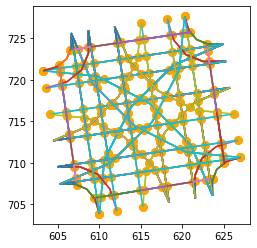

In [18]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
omega_values_gdf.plot(ax = ax, column='distance_a') # colouring of geometry_a according to distance
intersection_points_gdf.plot(ax = ax, marker = 'o', color = 'orange', markersize = 60)

plt.show()

#### Optional: Check angles for specific conflict points

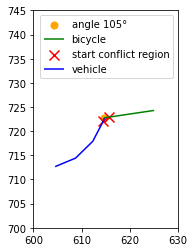

In [35]:
#input
conflict_number = 10
fig, ax = plt.subplots()

# has to be adapted for a different intersection
ax.set_xlim(600, 630) 
ax.set_ylim(700, 730)
ax.set_aspect('equal')

intersection_points_gdf.loc[[conflict_number],'geometry'].plot(ax = ax, marker = 'o', color = 'orange', markersize = 50)

omega_values_gdf = omega_values_gdf.set_geometry('geometry_a')
omega_values_gdf.loc[[conflict_number],'geometry_a'].plot(ax = ax, color = 'green')
omega_values_gdf.loc[[conflict_number],'geometry_a'].interpolate(omega_values_gdf.loc[conflict_number, 'om1_a']).plot(ax = ax, marker='x', markersize=100, color = 'red')

omega_values_gdf = omega_values_gdf.set_geometry('geometry_b')
omega_values_gdf.loc[[conflict_number],'geometry_b'].plot(ax = ax, color = 'blue')
omega_values_gdf.loc[[conflict_number],'geometry_b'].interpolate(omega_values_gdf.loc[conflict_number, 'om1_b']).plot(ax = ax, marker='x', markersize=100, color = 'red')


label1 = 'angle ' + str(round(omega_values_gdf.loc[[conflict_number],'angle'][conflict_number])) + '°'
label2 = omega_values_gdf.loc[[conflict_number],'RU_a'][conflict_number]
label3 = 'start conflict region'
label4 = omega_values_gdf.loc[[conflict_number],'RU_b'][conflict_number]
plt.legend([label1, label2, label3, label4])

plt.show()

#### Optional: Visualize several conflict points and their omeaga values

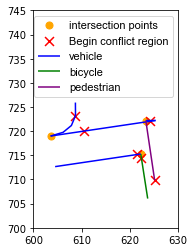

In [37]:
conflict_numbers = [56, 105, 45]
fig, ax = plt.subplots()

font = FontProperties()
font.set_family('Arial')
font.set_size(11)

# Set the limits and aspect ratio of the plot
ax.set_xlim(600, 630) 
ax.set_ylim(700, 745)
ax.set_aspect('equal')

# Initialize a set to keep track of added labels
added_labels = set()

# Loop through conflict_numbers
for i in conflict_numbers:
    # Plot intersection points
    intersection_points_gdf.loc[[i],'geometry'].plot(ax=ax, marker='o', color='orange', markersize=50, label='intersection points' if 'intersection points' not in added_labels else None)
    if 'intersection points' not in added_labels:
        added_labels.add('intersection points')
    
    # Plot road user a
    omega_values_gdf = omega_values_gdf.set_geometry('geometry_a')
    
    omega_values_gdf.loc[[i],'geometry_a'].interpolate(omega_values_gdf.loc[i, 'om1_a']).plot(ax=ax, marker='x', markersize=80, color='red', label='Begin conflict region' if 'Begin conflict region' not in added_labels else None)
    if 'Begin conflict region' not in added_labels:
        added_labels.add('Begin conflict region')
    
    road_user = omega_values_gdf.loc[i, 'RU_a']
    if road_user == "pedestrian": 
        omega_values_gdf.loc[[i],'geometry_a'].plot(ax = ax, color = 'purple', label='pedestrian' if 'pedestrian' not in added_labels else None)
        if 'pedestrian' not in added_labels:
            added_labels.add('pedestrian')
    elif road_user == "bicycle":
        omega_values_gdf.loc[[i],'geometry_a'].plot(ax = ax, color = 'green', label='bicycle' if 'bicycle' not in added_labels else None)
        if 'bicycle' not in added_labels:
            added_labels.add('bicycle')
    else:
        omega_values_gdf.loc[[i],'geometry_a'].plot(ax = ax, color = 'blue', label='vehicle' if 'vehicle' not in added_labels else None) 
        if 'vehicle' not in added_labels:
            added_labels.add('vehicle')
    
    # Plot road user b
    omega_values_gdf = omega_values_gdf.set_geometry('geometry_b')
    omega_values_gdf.loc[[i],'geometry_b'].interpolate(omega_values_gdf.loc[i, 'om1_b']).plot(ax=ax, marker='x', markersize=80, color='red', label='Begin conflict region' if 'Begin conflict region' not in added_labels else None)
    
    road_user = omega_values_gdf.loc[i, 'RU_b']
    if road_user == "pedestrian": 
        omega_values_gdf.loc[[i],'geometry_b'].plot(ax = ax, color = 'purple', label='pedestrian' if 'pedestrian' not in added_labels else None)
        if 'pedestrian' not in added_labels:
            added_labels.add('pedestrian')
    elif road_user == "bicycle":
        omega_values_gdf.loc[[i],'geometry_b'].plot(ax = ax, color = 'green', label='bicycle' if 'bicycle' not in added_labels else None)
        if 'bicycle' not in added_labels:
            added_labels.add('bicycle')
    else:
        omega_values_gdf.loc[[i],'geometry_b'].plot(ax = ax, color = 'blue', label='vehicle' if 'vehicle' not in added_labels else None) 
        if 'vehicle' not in added_labels:
            added_labels.add('vehicle')

# Display the legend
plt.legend(prop=font)
#plt.legend(prop=font, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('omega_values.png', dpi=600)
# Show the plot
plt.show()